# Import libraries

In [57]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.cm as cm

import seaborn as sns

import json

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

from joblib import Parallel
from joblib import delayed
from tqdm_joblib import tqdm_joblib

from collections import defaultdict

from tqdm import tqdm

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', None)

In [3]:
path_to_save = './../results/03c_features_analysis'

# Loading data

In [4]:
path_to_ftir_data= './../data/processed_data/ftir_features_long_list.csv'
path_to_features_description = './../data/processed_data/features_description.json'
path_to_samples_description = './../data/parsed_data/samples_description.csv'

## FTIR-features (*long-list*)

In [5]:
features_df = pd.read_csv(path_to_ftir_data, sep=';', index_col=0)

print(features_df.shape)
features_df.head(3)

(75, 4777)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,0.621029,1.356218,3.805731,1.639009,14.571275,0.581146,1.269121,3.561324,1.533751,0.039883,0.087097,0.244407,0.105259,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,0.685693,1.406955,4.238007,1.954410,17.314756,0.648254,1.330135,4.006609,1.847698,0.037439,0.076821,0.231399,0.106712,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,0.612609,1.320767,4.173611,1.573251,12.422929,0.566970,1.222371,3.862680,1.456045,0.045639,0.098396,0.310931,0.117206,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## Features description

In [6]:
with open(path_to_features_description, 'r', encoding='utf-8') as f:
    features_description = json.load(f)

## Samples description

In [7]:
samples_description = pd.read_csv(f'{path_to_samples_description}', sep=';', index_col=0)

print(samples_description.shape)
samples_description.head(3)

(75, 6)


,Row_ID,Division,Size,Fraction_hue,Fraction_grouped_hue,Class
division_1_size_bulk,1,1,bulk,$> 0$,$d > 5$,2
division_1_size_5,2,1,5,$< 5$,$2 < d \leq 5$,1
division_1_size_3,3,1,3,$< 3$,$2 < d \leq 5$,1


# Data wrangling

## Base parameters

In [70]:
hue = samples_description['Fraction_grouped_hue'].tolist()
target = samples_description['Class']

In [63]:
type_color_dict = {
    '$0< d \leq 2$': '#2166AC',
    '$2 < d \leq 5$': '#67A9CF',
    '$d > 5$': '#B2182B'
}

In [64]:
groups = list(type_color_dict.keys())

In [65]:
sns.set_theme()

## Dictionaty for features mapping to type

In [66]:
feature_to_types = defaultdict(list)

for feature_type, features in features_description.items():
    for feature in features:
        feature_to_types[feature].append(feature_type)

# Modeling

In [67]:
initial_features_df = features_df.copy()

print(initial_features_df.shape)
initial_features_df.head(3)

(75, 4777)


,$\overline{I}_{3800\text{–}2200}$,$\overline{I}_{3800\text{–}2400}$,$I_{3720}$,$\overline{I}_{3720 \pm 25}$,$\overline{I}_{3720 \pm 50}$,$I_{3533}$,$\overline{I}_{3533 \pm 25}$,$\overline{I}_{3533 \pm 50}$,$I_{3405}$,$\overline{I}_{3405 \pm 25}$,$\overline{I}_{3405 \pm 50}$,$I_{3302}$,$\overline{I}_{3302 \pm 25}$,$\overline{I}_{3302 \pm 50}$,$I_{3201}$,$\overline{I}_{3201 \pm 25}$,$\overline{I}_{3201 \pm 50}$,$I_{3132}$,$\overline{I}_{3132 \pm 25}$,$\overline{I}_{3132 \pm 50}$,$I_{3001}$,$\overline{I}_{3001 \pm 25}$,$\overline{I}_{3001 \pm 50}$,$I_{2926}$,$\overline{I}_{2926 \pm 25}$,...,"$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\overline{I}_{881 \pm 50}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 3800\text{–}2400}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2200}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 2400\text{–}2200}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 3800\text{–}2400}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}900}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 2400\text{–}2200}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1800\text{–}1500}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}900}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1500\text{–}1300}}$","$\frac{\Sigma I_{p,\ 1800\text{–}1500}}{\Sigma I_{p,\ 1300\text{–}900}}$","$\frac{\Sigma I_{p,\ 1500\text{–}1300}}{\Sigma I_{p,\ 1300\text{–}900}}$"
division_1_size_bulk,0.425422,0.462285,0.084601,0.076032,0.071260,0.506784,0.511390,0.524201,0.938564,0.935451,0.928330,1.000000,0.967122,0.963302,0.815223,0.819056,0.822279,0.720771,0.714901,0.710538,0.498252,0.499682,0.501630,0.422644,0.422996,...,0.030859,0.067391,0.189109,0.081443,1.068628,15.571275,0.621029,1.356218,3.805731,1.639009,14.571275,0.581146,1.269121,3.561324,1.533751,0.039883,0.087097,0.244407,0.105259,2.183824,6.128105,2.639183,2.806135,1.208515,0.430669
division_1_size_5,0.439080,0.480354,0.038211,0.036371,0.046173,0.652508,0.657052,0.667775,1.000000,0.985547,0.976453,0.942571,0.941360,0.940593,0.814723,0.815564,0.814640,0.704920,0.702329,0.701261,0.486172,0.487186,0.494274,0.448983,0.445307,...,0.030350,0.062274,0.187581,0.086505,1.057754,18.314756,0.685693,1.406955,4.238007,1.954410,17.314756,0.648254,1.330135,4.006609,1.847698,0.037439,0.076821,0.231399,0.106712,2.051873,6.180616,2.850268,3.012183,1.389106,0.461163
division_1_size_3,0.428649,0.463028,0.074497,0.065544,0.062297,0.598526,0.602768,0.611808,1.000000,0.959284,0.951557,0.937402,0.935431,0.933702,0.760651,0.763172,0.764610,0.637583,0.636283,0.638100,0.450708,0.455257,0.473817,0.547936,0.532374,...,0.032330,0.069703,0.220262,0.083028,1.080496,13.422929,0.612609,1.320767,4.173611,1.573251,12.422929,0.566970,1.222371,3.862680,1.456045,0.045639,0.098396,0.310931,0.117206,2.155971,6.812848,2.568116,3.159990,1.191164,0.376952


## *One-factor* analysis

### Calculation process

In [77]:
def of_analysis(feature, features_df, target, n_splits=5):
    X_full_raw = features_df[[feature]].values
    y_full = target.values

    # --- масштабирование всего трейна ---
    scaler = StandardScaler()
    X_full = scaler.fit_transform(X_full_raw)

    mean_val = scaler.mean_[0]
    std_val = np.sqrt(scaler.var_[0])

    estimator = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        multi_class='multinomial',
        max_iter=10_000,
        random_state=42
    )
    estimator.fit(X_full, y_full)
    y_score = estimator.predict_proba(X_full)

    try:
        metric_ovr = roc_auc_score(y_true=y_full, y_score=y_score, multi_class='ovr')
        metric_ovo = roc_auc_score(y_true=y_full, y_score=y_score, multi_class='ovo')
    except ValueError:
        metric_ovr = None
        metric_ovo = None

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores_ovr_cv = []
    scores_ovo_cv = []

    for train_idx, test_idx in skf.split(X_full_raw, y_full):
        X_train_raw, X_test_raw = X_full_raw[train_idx], X_full_raw[test_idx]
        y_train, y_test = y_full[train_idx], y_full[test_idx]

        scaler_cv = StandardScaler()
        X_train = scaler_cv.fit_transform(X_train_raw)
        X_test = scaler_cv.transform(X_test_raw)

        estimator_cv = LogisticRegression(
            penalty='l2',
            solver='lbfgs',
            multi_class='multinomial',
            max_iter=1000,
            random_state=42
        )
        estimator_cv.fit(X_train, y_train)

        try:
            y_score_cv = estimator_cv.predict_proba(X_test)
            scores_ovr_cv.append(roc_auc_score(y_test, y_score_cv, multi_class='ovr'))
            scores_ovo_cv.append(roc_auc_score(y_test, y_score_cv, multi_class='ovo'))
        except ValueError:
            scores_ovr_cv.append(np.nan)
            scores_ovo_cv.append(np.nan)

    return {
        'Feature': feature,
        '$ROC-AUC_{ovr}$': metric_ovr,
        '$ROC-AUC_{ovo}$': metric_ovo,
        '$ROC-AUC_{ovr}^{CV}$': np.nanmean(scores_ovr_cv),
        '$ROC-AUC_{ovo}^{CV}$': np.nanmean(scores_ovo_cv),
        '$mean$': mean_val,
        '$std$': std_val
    }


In [78]:
features_list = features_df.columns.tolist()

with tqdm_joblib(desc='Calculation progress', total=len(features_list)):
    results = Parallel(n_jobs=-1, backend='loky')(
        delayed(of_analysis)(
            feature,
            features_df,
            target,
            n_splits=5
        )
        for feature in features_list
    )

df_metrics = pd.DataFrame(results)

Calculation progress:   0%|          | 0/4777 [00:00<?, ?it/s]

In [79]:
df_metrics = pd.DataFrame(results)

df_metrics = df_metrics.sort_values(by=['$ROC-AUC_{ovr}$', '$ROC-AUC_{ovo}$'], ascending=[False, False])

print(df_metrics.shape)
df_metrics.head(3)

(4777, 7)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovo}$,$ROC-AUC_{ovr}^{CV}$,$ROC-AUC_{ovo}^{CV}$,$mean$,$std$
1921,$\frac{I_{3132}}{\overline{I}_{2926 \pm 25}}$,0.880694,0.886057,0.881291,0.885333,0.963022,0.459795
1920,$\frac{I_{3132}}{I_{2926}}$,0.880195,0.885557,0.883760,0.887833,0.946547,0.468687
1995,$\frac{\overline{I}_{3132 \pm 25}}{I_{2926}}$,0.879387,0.884808,0.882525,0.886722,0.947679,0.468232


### Mapping features with their types

In [80]:
rows = []

for _, row in df_metrics.iterrows():
    feature = row['Feature']
    feature_types = feature_to_types.get(feature, [])

    for feature_type in feature_types:
        row_copy = row.copy()
        row_copy['Feature_Type'] = feature_type
        rows.append(row_copy)

df_metrics_expanded = pd.DataFrame(rows)

print(df_metrics_expanded.shape)
df_metrics_expanded.head(3)

(9554, 8)


,Feature,$ROC-AUC_{ovr}$,$ROC-AUC_{ovo}$,$ROC-AUC_{ovr}^{CV}$,$ROC-AUC_{ovo}^{CV}$,$mean$,$std$,Feature_Type
1921,$\frac{I_{3132}}{\overline{I}_{2926 \pm 25}}$,0.880694,0.886057,0.881291,0.885333,0.963022,0.459795,engineered_features_intervals_3800_2200
1921,$\frac{I_{3132}}{\overline{I}_{2926 \pm 25}}$,0.880694,0.886057,0.881291,0.885333,0.963022,0.459795,engineered_features
1920,$\frac{I_{3132}}{I_{2926}}$,0.880195,0.885557,0.883760,0.887833,0.946547,0.468687,engineered_features_peaks_3800_2200


### Visualization

In [81]:
feature_types = [
    'base_features_peaks_3800_2200',
    'base_features_intervals_3800_2200',
    'base_features_peaks_1900_800',
    'base_features_intervals_1900_800',
    'engineered_features_peaks_3800_2200',
    'engineered_features_intervals_3800_2200',
    'engineered_features_peaks_1900_800',
    'engineered_features_intervals_1900_800'
]

In [108]:
PLOT_STYLE = {
    'TITLE_FONT_SIZE': 18,
    'TITLE_FONTSTYLE': 'normal',
    'X_LABEL_FONT_SIZE': 14,
    'Y_LABEL_FONT_SIZE': 14,
    'X_TICK_LABEL_FONT_SIZE': 14,
    'Y_TICK_LABEL_FONT_SIZE': 16,
    'X_LABELPAD': 8,
    'Y_LABELPAD': 8,
    'X_NBINS': 8,
    'BAR_WIDTH': 0.7,
    'BAR_ALPHA': 0.85,
    'FIG_DPI': 300,
    'SUBPLOT_WIDTH': 5,
    'SUBPLOT_HEIGHT': 4,
    'TOP_N': 5,
    'COLOR_MAP': {
        'base': 'royalblue',
        'engineered': 'seagreen'
    },
    'LEGEND_FONT_SIZE': 12
}

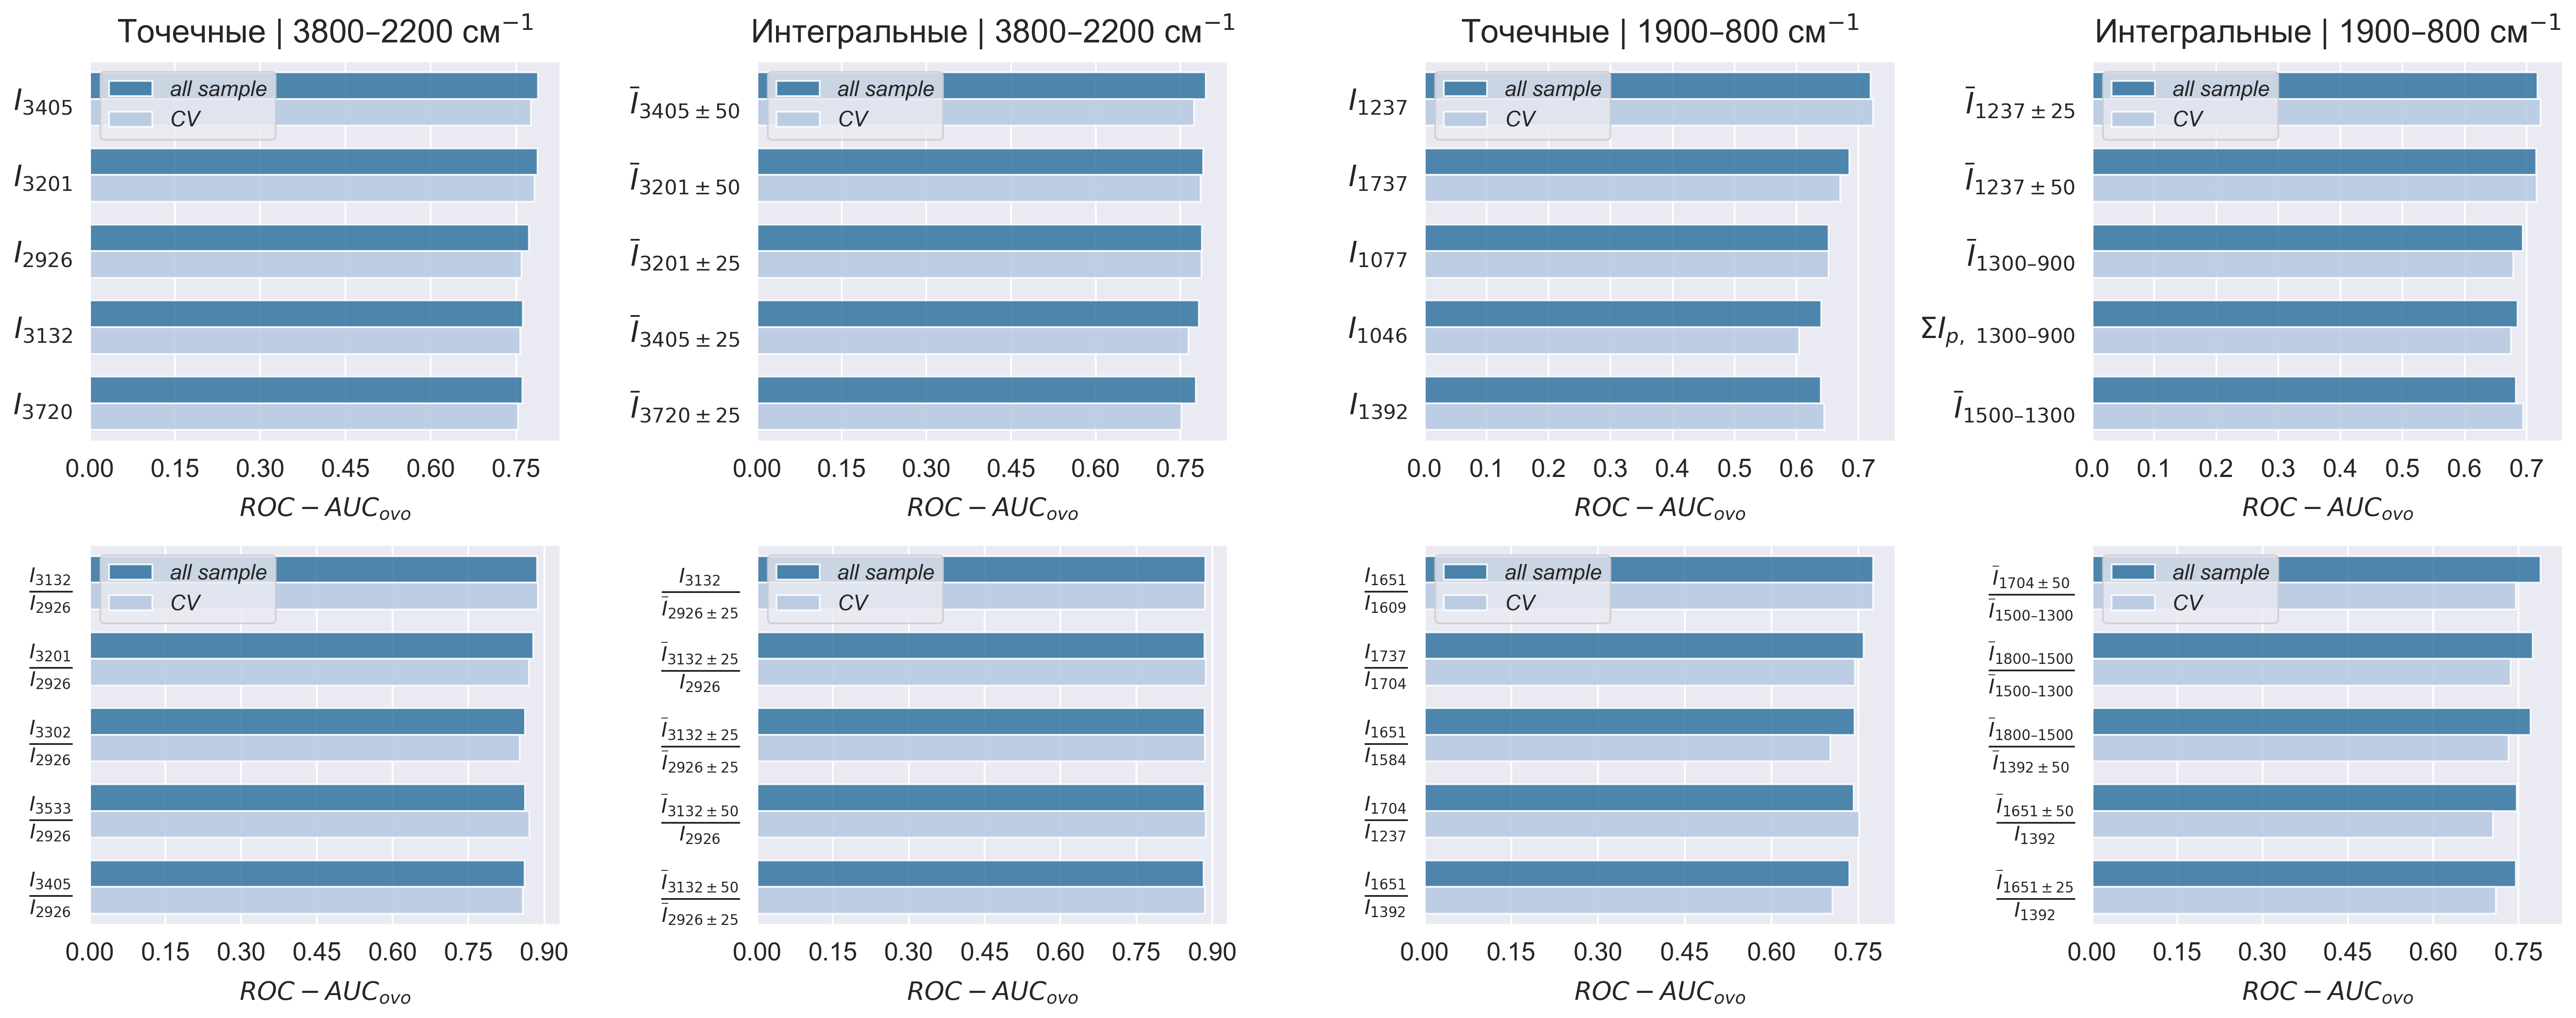

In [109]:
nrows, ncols = 2, 4

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(ncols * PLOT_STYLE['SUBPLOT_WIDTH'], nrows * PLOT_STYLE['SUBPLOT_HEIGHT']),
    dpi=PLOT_STYLE['FIG_DPI']
)
axes = axes.flat

for i, feature_type in enumerate(feature_types):
    subset = df_metrics_expanded[df_metrics_expanded['Feature_Type'] == feature_type]
    
    result_df = subset.sort_values(by='$ROC-AUC_{ovo}$', ascending=False).head(PLOT_STYLE['TOP_N']).copy()

    result_df = result_df[['Feature', '$ROC-AUC_{ovo}$', '$ROC-AUC_{ovo}^{CV}$']]
    
    result_df = result_df.melt(id_vars='Feature', var_name='Type', value_name='ROC-AUC')
    result_df['Type'] = result_df['Type'].map({
        '$ROC-AUC_{ovo}$': 'all sample',
        '$ROC-AUC_{ovo}^{CV}$': 'CV'
    })


    kind = 'engineered' if 'engineered' in feature_type else 'base'
    color = PLOT_STYLE['COLOR_MAP'][kind]

    ax = axes[i]
    
    sns.barplot(
        data=result_df,
        x='ROC-AUC',
        y='Feature',
        hue='Type',
        ax=ax,
        palette=['#1f77b4', '#aec7e8'],
        width=PLOT_STYLE['BAR_WIDTH'],
        alpha=PLOT_STYLE['BAR_ALPHA']
    )

    if i < 4:
        label = 'Точечные' if 'peaks' in feature_type else 'Интегральные'
        a, b = [s for s in feature_type.split('_') if s.isdigit()][-2:]
        title = f'{label} | {a}–{b} см$^{{-1}}$'
        
        ax.set_title(
            title,
            fontsize=PLOT_STYLE['TITLE_FONT_SIZE'],
            fontstyle=PLOT_STYLE['TITLE_FONTSTYLE'],
            pad=10
        )

    ax.set_xlabel('$ROC-AUC_{ovo}$', fontsize=PLOT_STYLE['X_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['X_LABELPAD'])

    ax.set_ylabel('', fontsize=PLOT_STYLE['Y_LABEL_FONT_SIZE'], labelpad=PLOT_STYLE['Y_LABELPAD'])
    
    ax.tick_params(axis='x', labelsize=PLOT_STYLE['X_TICK_LABEL_FONT_SIZE'])
    ax.tick_params(axis='y', labelsize=PLOT_STYLE['Y_TICK_LABEL_FONT_SIZE'])
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=PLOT_STYLE['X_NBINS']))

    legend = ax.legend(loc='upper left', fontsize=PLOT_STYLE['LEGEND_FONT_SIZE'], frameon=True)
    for text in legend.get_texts():
        text.set_fontstyle('italic')


for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

# plt.savefig(f'{path_to_save}/roc_auc_barplots.png', dpi=600)

plt.show()

### *Hard-check* factor selection

In [48]:
of_features_to_save = (
    df_metrics
    .loc[
        (df_metrics['$ROC-AUC_{ovo}$'] >= 0.65)
        (df_metrics['$ROC-AUC_{ovo}$'])
    ]['Feature']
).tolist()

print(
    f'Число фичей',
    f'(*) до отбора: {len(df_metrics["Feature"].unique())}',
    f'(*) после отбора: {len(of_features_to_save)}',
    f'Доля фичей, прошедших однофакторный отбор: {round(len(of_features_to_save) / len(df_metrics["Feature"].unique()), 2) * 100}%',
    sep='\n'
)

Число фичей
(*) до отбора: 4777
(*) после отбора: 1269
Доля фичей, прошедших однофакторный отбор: 27.0%


##